# QPM : Assignement 4

## Librairies

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Functions

In [2]:
'''
Function get_multi_timeseries:

Returns the full time series of price metrics (Open, High, Low, Close, Adj Close, Volume, etc.)
for a list of given stock tickers, over a specified time period and interval.

Inputs:
    - list_underlying: list of str ; tickers of the desired stocks.
    - startd / endd: str ; start and end dates (inclusive) defining the time range to retrieve, in format "YYYY-MM-DD" 

Output:
    - DataFrame with:
        - index: pandas Timestamps (dates in ascending order),
        - columns: MultiIndex with first level = metrics (e.g., "Close"), 
                   second level = stock tickers.


Function: annual_mean_returns ; annual_volatility ; sharpe_ratio

Returns the annual mean, return and sharpe ratio of each stocks.

Input: - df: DataFrame (float) ; DataFrame of time series of close price of each stocks.

Output: DataFrame (float) ; 1 column, indexed by the stocks tickers.
'''

def get_multi_timeseries(list_underlying,startd,endd):
    return yf.download(list_underlying,interval="1d",start=startd,end=endd)

def annual_mean_return(df) :
    return df.mean() * 252

def annual_volatility(df) :
    return df.std() * np.sqrt(252)

def sharpe_ratio(df) :
    return annual_mean_return(df) / annual_volatility(df)

In [3]:
def expected_ret_cov(rets):
    """
    Computes the expected returns and the covariance matrix of asset returns.
    
    Parameters:
        rets (DataFrame): Historical returns of the assets.

    Returns:
        expected_returns (Series): Mean return of each asset.
        cov_matrix (DataFrame): Covariance matrix of asset returns.
    """
    expected_returns=rets.mean()
    cov_matrix=rets.cov()
    return expected_returns,cov_matrix

def calculate_mvp_portfolio(ret, ret_level):
    """
    Computes the weights of the Mean-Variance (target return) portfolio,
    given a target return level. The optimization minimizes portfolio volatility 
    subject to:
        - full investment constraint (sum of weights = 1)
        - expected portfolio return equals target return
        - no short selling (weights between 0 and 1)

    Parameters:
        ret (DataFrame): Historical asset returns.
        ret_level (float): Target annualized return for the portfolio.

    Returns:
        list: Optimal weights for the MVP portfolio.
    """
    # Objective function: annualized portfolio volatility
    def find_port_variance(weights):
        cov = ret.cov()
        port_var = np.sqrt(np.dot(weights.T, np.dot(cov, weights)) * 12)
        return port_var

    # Constraint: weights must sum to 1
    def weight_cons(weights):
        return np.sum(weights) - 1
    
    # Constraint: expected portfolio return equals the target level
    def expected_ret(weights) :
        return np.mean(np.dot(ret.mean().values, weights)) - ret_level

    # Bounds: no short-selling (weights between 0 and 1)
    bounds_lim = [(0, 1) for x in range(len(ret.columns))]
    # Initial guess: equal-weighted portfolio 
    init = [1/len(ret.columns) for i in range(len(ret.columns))]
    # Constraints for the optimizer
    constraint = [{'type': 'eq', 'fun': weight_cons},
                  {'type': 'eq', 'fun': expected_ret}]
    # Optimization using SLSQP method
    optimal = minimize(fun=find_port_variance,
                       x0=init,
                       bounds=bounds_lim,
                       constraints=constraint,
                       method='SLSQP'
                       )

    return list(optimal['x'])

def calculate_gmv_portfolio(ret):
    """
    Computes the weights of the Global Minimum Variance (GMV) portfolio.
    The optimization minimizes portfolio volatility subject to:
        - full investment constraint (sum of weights = 1)
        - no short selling (weights between 0 and 1)

    Parameters:
        ret (DataFrame): Historical asset returns.

    Returns:
        list: Optimal weights for the GMV portfolio.
    """
    # Objective function: annualized portfolio volatility
    def find_port_variance(weights):
        cov = ret.cov()
        port_var = np.sqrt(np.dot(weights.T, np.dot(cov, weights)) * 12)
        return port_var
    
    # Constraint: weights must sum to 1
    def weight_cons(weights):
        return np.sum(weights) - 1

    # Bounds: no short-selling
    bounds_lim = [(0, 1) for x in range(len(ret.columns))]
    # Initial guess: equal-weighted
    init = [1/len(ret.columns) for i in range(len(ret.columns))]
    # Constraint list
    constraint = {'type': 'eq', 'fun': weight_cons}
    # Optimization
    optimal = minimize(fun=find_port_variance,
                       x0=init,
                       bounds=bounds_lim,
                       constraints=constraint,
                       method='SLSQP'
                       )

    return list(optimal['x'])

**Q4.0 From the data that we used for the previous assignment, select the
following 10 companies**

Let's import the stocks prices of SP500 companies

In [4]:
URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

In [5]:
'''
Assign value to parameters
'''
tickers = pd.read_html(URL)[0]['Symbol'].tolist()
start_date = "2000-01-01"
end_date = "2022-12-31"
raw_market_data=get_multi_timeseries(tickers,start_date,end_date)
close_price_data = raw_market_data.xs("Close",axis = 1) #Extract the Close price for each tickers.
close_price_data.index = pd.to_datetime(close_price_data.index, format = '%Y/%m/%d') #Change index format from Timestamp to DateTime

/var/folders/lr/7kzpljcn0zl52pt8zpscgfj40000gn/T/ipykernel_13041/305190281.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  return yf.download(list_underlying,interval="1d",start=startd,end=endd)
[*********************100%***********************]  502 of 502 completed

7 Failed downloads:
['VLTO', 'SW', 'GEV', 'KVUE', 'SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2022-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 946702800, endDate = 1672462800")')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2022-12-31)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


Let's clean the historical prices keeping only the ones from 2000-01-01 to 2022-12-31 for companies with enough data

In [6]:
close_price_focus = close_price_data.dropna(axis = 1, how = "all") #drop the columns with only NaN entries
mask = (close_price_focus.isna().sum() <= 100) # drop the company names that have more than 100 missing observations
close_price_focus = close_price_focus.loc[:,mask]
close_price_focus.describe()

Ticker,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WRB,WSM,WST,WY,XEL,XOM,YUM,ZBRA
count,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,...,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000,5787.000000
mean,41.962047,28.402888,35.124440,15.822778,117.181149,50.227273,26.065057,62.980588,71.852418,32.123512,...,13.643675,19.643270,11.615153,20.327085,68.789311,16.454026,23.368829,42.942787,40.024357,99.453604
std,35.573140,42.483030,30.684548,12.991039,152.396637,40.380351,16.503054,56.485868,77.145966,20.386817,...,7.418506,10.889359,10.183526,18.089442,99.831149,7.305811,17.906286,16.940730,33.988455,124.255846
min,6.509984,0.197156,6.980703,1.208433,8.317787,10.716372,4.512144,13.011336,4.834495,8.951228,...,0.296817,9.271348,0.569756,1.586850,3.241057,4.141687,2.320535,14.346547,2.907504,15.194444
25%,19.106953,1.573487,13.719811,5.008594,28.400000,22.840282,14.718868,23.526144,24.179016,17.186456,...,7.839882,11.668126,4.892213,9.228344,11.626058,10.360281,10.087437,30.062745,12.205128,31.800000
50%,27.257694,10.735357,19.039417,10.491580,38.919998,30.191591,22.724077,32.672619,39.939999,23.462345,...,12.569791,13.738816,7.516781,13.469359,20.533581,14.003805,15.159497,45.617680,29.157364,44.099998
75%,55.511929,32.897118,40.576530,25.664752,129.599998,67.178616,34.316521,85.836784,86.475002,43.017187,...,18.630046,22.772503,16.683714,24.616419,82.448322,21.824926,34.278751,55.169380,56.610817,101.654999
max,174.417160,178.645645,132.416656,60.496162,688.369995,176.538544,90.189819,254.354340,342.269989,89.207031,...,34.033939,50.998806,47.730026,103.032516,467.231873,37.775898,69.950798,104.856056,129.862152,614.549988


In [7]:
#Select the stocks we are interested in and transform them into monthly returns
monthly_ret=close_price_focus.loc[:,["MMM","AOS","ABT","ADM","ADBE","ADP","AES","AFL","A","AKAM"]].resample('M').last().pct_change()

**Q4.1 Choose the estimation window to be Test = 60 months of monthly returns. Call this the estimation sample. Use the estimation sample to compute the following two portfolio strategies:**

In [8]:
samples=monthly_ret.iloc[:,:60]
expected_returns,cov_matrix=expected_ret_cov(samples)

**Mean-Variance portfolio**

In [9]:
return_wanted = 0.06
w_mvp=calculate_mvp_portfolio(samples,0.15)

**Global Mininimum Variance portfolio**

In [10]:
w_gmv=calculate_gmv_portfolio(samples)
print(w_gmv)

[0.23143224082739092, 0.025562213538467063, 0.3786812670479588, 0.10288681671647348, 0.0, 0.22224138065011118, 0.001722041917287421, 0.027063887000814343, 5.854691731421724e-18, 0.010410152301496963]


In [11]:
np.dot(samples.mean().values, w_gmv)
#samples.mean().values
#w_gmv

0.010459812682584647

Comparison of weights for both strategies

In [12]:
w=pd.concat([pd.DataFrame(w_mvp),pd.DataFrame(w_gmv)],axis=1)
w.columns=['MVP','GMV']
print(w)
print(f"total weight {w.sum()}")

            MVP           GMV
0  5.438065e-16  2.314322e-01
1  4.555357e-11  2.556221e-02
2  1.133303e-16  3.786813e-01
3  6.497619e-15  1.028868e-01
4  1.000000e+00  0.000000e+00
5  2.085554e-15  2.222414e-01
6  2.690130e-16  1.722042e-03
7  5.978771e-15  2.706389e-02
8  2.024213e-16  5.854692e-18
9  8.214038e-15  1.041015e-02
total weight MVP    1.0
GMV    1.0
dtype: float64


**Q4.2 Now use a rolling window of Test = 60 months to estimate the portfolio weights for the two strategies listed above for each of the T − Test months. That is, repeat the calculations of the previous question for all the dates after the first 60 months**

In [13]:
#loop for each periods
w_mvp_df=pd.DataFrame(index=monthly_ret.index,columns=monthly_ret.columns)
w_gmv_df=pd.DataFrame(index=monthly_ret.index,columns=monthly_ret.columns)

for k in range(60,len(monthly_ret.index)):
    expected_returns,cov_matrix=expected_ret_cov(monthly_ret.iloc[k-60:k])
    w_mvp_df.iloc[k]=calculate_mvp_portfolio(monthly_ret.iloc[k-60:k], 0.15)
    w_gmv_df.iloc[k]=calculate_gmv_portfolio(monthly_ret.iloc[k-60:k])

<Axes: xlabel='Date'>

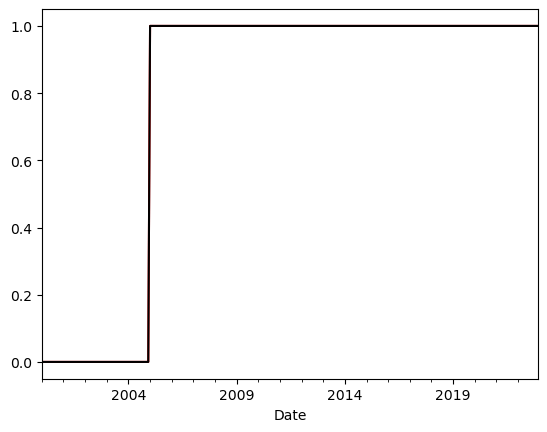

In [14]:
w_mvp_df.sum(axis=1).plot(label="MVP leverage", c='r')
w_gmv_df.sum(axis=1).plot(label="GMV leverage", c='k')

**Q4.3 Use the time-series of portfolios weights for each of the two portfolio
strategies, to compute the out-of-sample portfolio returns. That is, for
each of the two portfolio strategies that you estimate at each date t,
compute its out-of-sample return in month t + 1.**

In [15]:
#We shift the weigths to t-1 and apply them to the returns made in period t.
gmv_pfo_rets=(w_gmv_df.shift(1)*monthly_ret).sum(axis=1)
mvp_pfo_rets=(w_mvp_df.shift(1)*monthly_ret).sum(axis=1)

Text(0.5, 1.0, 'Global Minimum Variance Portfolio')

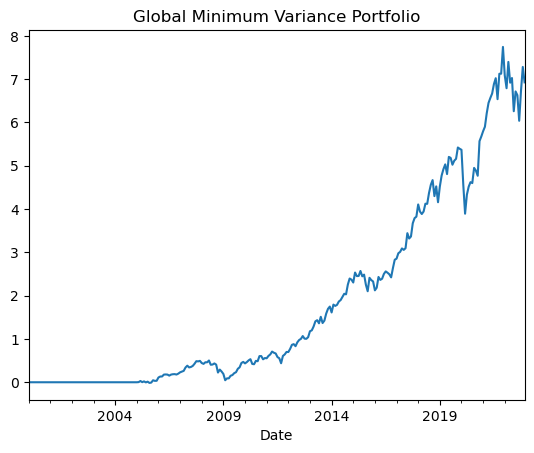

In [16]:
#Plot of the investment result for the Global Minimum Variance Portfolio.
((gmv_pfo_rets+1).cumprod()-1).plot()
plt.title("Global Minimum Variance Portfolio")

Text(0.5, 1.0, 'Mean Variance Portfolio')

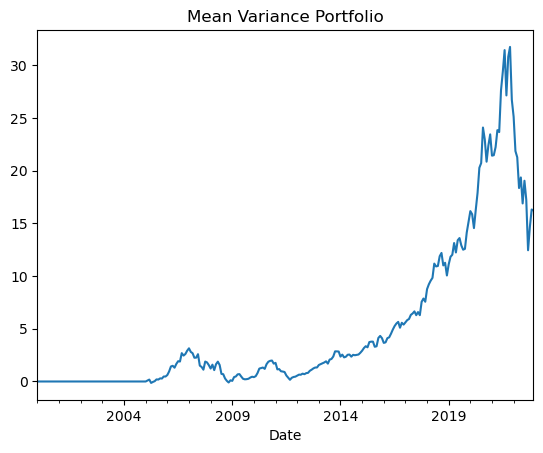

In [17]:
##Plot of the investment result for the Mean-Variance Portfolio.
((mvp_pfo_rets+1).cumprod()-1).plot()
plt.title("Mean Variance Portfolio")

**Q4.4 Now, compute the Sharpe ratio of the out-of-sample returns for the two
portfolio strategies. Which strategy has the higher Sharpe ratio?**

In [18]:
print(f"GMV SR : {sharpe_ratio(gmv_pfo_rets)}")
print(f"MVP SR : {sharpe_ratio(mvp_pfo_rets)}")

GMV SR : 3.4265482145926502
MVP SR : 2.511753796377351


The strategy with higher Sharpe Ratio is the one based on Global Minimum Variance.

We save the data for next time

In [19]:
monthly_ret.to_csv("monthly_ret.csv")